# Calculating yields

In [3]:
from cameo import load_model, fba
model_original = load_model('data/iJO1366.xml.gz')

## Product yield

In [4]:
model = model_original.copy()

Calculating the yield of a product is straigtforward. First one sets the producing reaction a new objective of the model.

In [5]:
model.objective = model.reactions.EX_ac_e

Then one determines the maximum production flux by solving the model.

In [6]:
model.solve()
model.reactions.EX_ac_e.flux

29.093467336683496

Dividing the production flux by the uptake flux of the carbon source (in this case glucose) yields the molar yield (mol product / mol glucose).

In [7]:
model.reactions.EX_ac_e.flux / (-1. * model.reactions.EX_glc__D_e.flux)

2.9093467336683494

## Exercise (15 min)

* Convert the yield into a C-mol (product) / C-mol (carbon source) yield.
* Calculate a mass yield instead of molar yield (g (product) / g (carbon source))

## Biomass yield

In [8]:
model = model_original.copy()

In [9]:
model.solve()
gDW_biomass_per_mmol_glucose = model.reactions.BIOMASS_Ec_iJO1366_core_53p95M.flux / (-1. * model.reactions.EX_glc__D_e.flux)
gDW_biomass_per_mmol_glucose

0.09823718127269793

## Excercise (10 min)

The units of this yield are gDW (Biomass) / mmol (glucose). Convert this number into a mass yield.

## Growth vs. Product yield

## Exercise (30 min)

In the previous section we calculated theoretical maximum yields in the absence of competing objectives. But how does product yield vary with growth for example?

* Determina molar, mass, and c-mol yields of acetate for the following growth rates (plot them using the code snippet below).
* How do the yields looks like for anaerobic conditions?

In [10]:
model = model_original.copy()

In [18]:
growth_rates = [0.0, 0.10915242, 0.21830485, 0.32745727, 0.43660969, 0.54576212, 0.65491454, 0.76406697, 0.87321939, 0.98237181]

Fill in your own product fluxes here (needs to be a list).

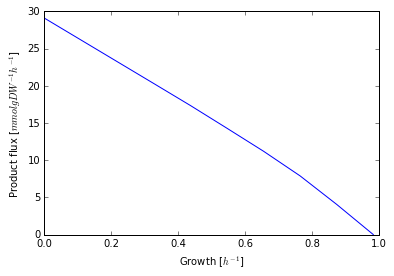

In [23]:
import matplotlib.pyplot as plt
plt.plot(growth_rates, product_fluxes)
plt.xlabel('Growth [$h^{-1}$]')
plt.ylabel('Product flux [$mmol gDW^{-1} h^{-1}$]')
plt.show()

Fill in your own product yields here (needs to be a list).

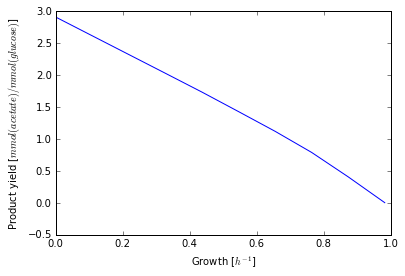

In [42]:
plt.plot(growth_rates, yields)
plt.xlabel('Growth [$h^{-1}$]')
plt.ylabel('Product yield [$mmol(acetate) / mmol(glucose)$]')
plt.show()